# グローバー探索量子アルゴリズムをとことん実装する

グローバー探索アルゴリズムは、ソートされていないN個のデータがあったときに、$O(\sqrt N)$回のクエリで目的のデータにアクセスするための方法である。古典コンピュータでは$O(N)$回のクエリが必要であるので、$N$が$n$ビットのランダムアクセスメモリ（$N=2^n$）のような場合には指数的な加速を可能とする。例えば、ある効率よく計算できるブール関数$f:\{0,1\}^n \rightarrow \{ 0,1\}$に対して、$f(x)=0$となる$x \in \{0,1\}^n$を見つけるような場合に利用できる。古典アルゴリズムの全探索部分をすべからく平方根（quadratic）に高速化してくれるので、SAT問題など古典ベストアルゴリズムを量子を用いてさらに加速することができる。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.gate import to_matrix_gate
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算
from qulacs import Observable
import math
from qulacs.gate import DephasingNoise,DepolarizingNoise

In [2]:
def show_distribution(state,nqubits):
    plt.bar([i for i in range(pow(2,nqubits))],abs(state.get_vector()))
    plt.show()

初期状態としてすべてのビット列が重ね合わさった状態を準備する。

In [3]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard = QuantumCircuit(nqubits)

for i in range(nqubits):
    Hadamard.add_gate(H(i))

Hadamard.update_quantum_state(state)
#state.get_vector()    

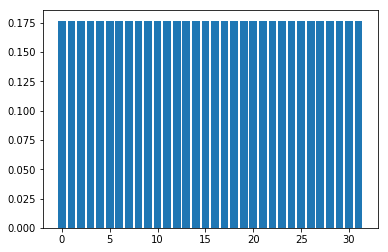

In [4]:
show_distribution(state,nqubits)

グローバーアルゴリズムでは、特定の target 状態の係数に-1を付けるフリップ演算子 target_flip と、初期状態のすべてのビット列が重ね合わさった状態（$|+\rangle ^{\otimes n}$）に-1をつけるフリップ演算子 initial_flip を繰り返し作用させることによって初期状態から終状態の２状態間の回転を誘導することになる。ここでは target 状態としてすべて1の状態 $|11...1\rangle$ を選んだ。実際には $f(x)=0$ を満たすような状態を取り出すといった場合に利用されることになり、このような場合には、関数 $f$ を量子コンピュータ上で実行し、$\sum _x |x\rangle  \rightarrow \sum _x (-1)^{f(x) \oplus 1}|x\rangle $のような量子演算がフリップ演算子となる。$f$を構成するところは$n$に対して多項式（$N=2^n$に対しては対数多項式）であるとしているので本質ではないため今回は $|11...1\rangle$ をターゲットとする。


qulacsの特殊ゲート `to_matrix_gate` を使うと好きな `control_index` の量子ビットが好きなビット値 `control_with_value` の場合に作用する制御量子演算を実現できる。今回は、nqubits-1番目までの量子ビットがすべて1の場合にnqubits番目の量子ビットにZを作用させる（$|111...1 \rangle$のみ-1をつけるフリップ演算子を定義する）。

In [6]:
target_flip = to_matrix_gate(Z(nqubits-1))
# 1st-qubitが0の場合だけゲートを作用
for i in range(nqubits-1):
    control_index = i
    control_with_value = 1
    target_flip.add_control_qubit(control_index, control_with_value)

実際そのような作用になっていることを確認しておく。

In [7]:
hoge = state.copy()
target_flip.update_quantum_state(hoge)
print(hoge.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


同様にして、初期状態のフリップ演算子を作る。すべての量子ビットにアダマール演算とパウリX演算を作用（target_flipの前後に共役に作用）させることで初期状態のフリップ演算子が作れる。

In [8]:
initial_flip = QuantumCircuit(nqubits)

for i in range(nqubits):
    initial_flip.add_gate(H(i))
    initial_flip.add_gate(X(i))

initial_flip.add_gate(target_flip)

for i in range(nqubits):
    initial_flip.add_gate(X(i))
    initial_flip.add_gate(H(i))

フリップ演算子を作用させて確率分布の変化を見よう。全部1の状態（一番右側）の確率が大きくなっている。

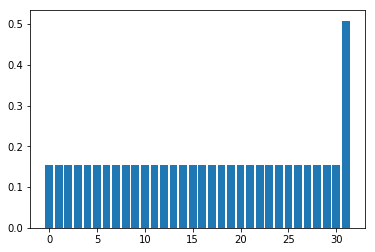

In [9]:
#初期状態の準備
state.set_zero_state()
Hadamard.update_quantum_state(state)

#フリップ演算子を作用
target_flip.update_quantum_state(state)
initial_flip.update_quantum_state(state)
show_distribution(state,nqubits)

これを何回か繰り返して、target状態の確率がどのように変化するか見ておく。

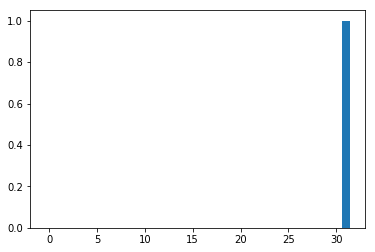

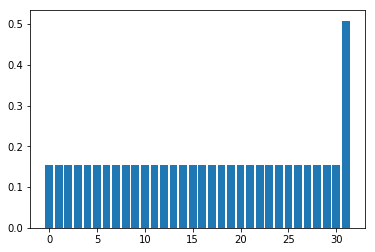

0.5082329989778311


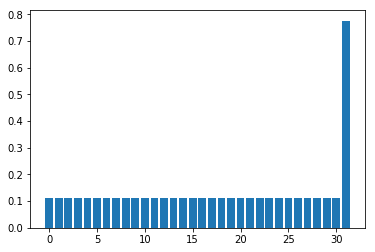

0.776160177786797


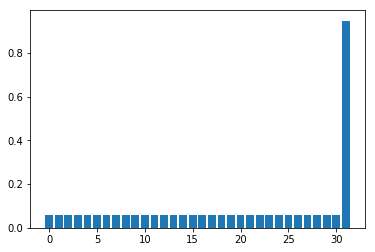

0.9470673343724136


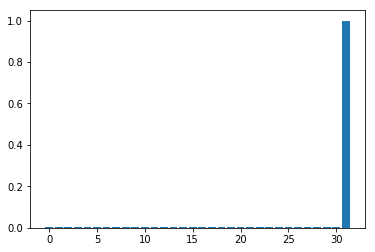

0.9995910741614789


In [10]:
state.set_zero_state()

#内積を評価するために target stateを作っておく
target_state = QuantumState(nqubits)
target_state = state.copy()
for i in range(nqubits):
    X(i).update_quantum_state(target_state)

#すべての計算基底の重ね合わせ状態を作る
Hadamard.update_quantum_state(state)
show_distribution(target_state,nqubits)

for i in range(4):
    target_flip.update_quantum_state(state)
    initial_flip.update_quantum_state(state)
    show_distribution(state,nqubits)
    print(np.linalg.norm(inner_product(state, target_state)))

4回ほどでほぼ確率１で target 状態を得ることができた。

前準備ができたので、量子ビット数を変えて、target状態が得られるのに必要な繰り返し回数を計算してみる

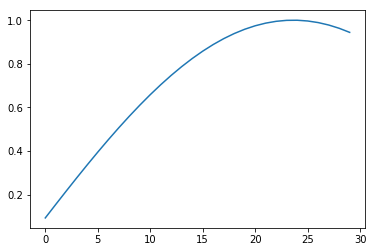

In [11]:
nqubits = 10
state = QuantumState(nqubits)
state.set_zero_state()

# transversal Hadamard gateを定義する
Hadamard = QuantumCircuit(nqubits)
for i in range(nqubits):
    Hadamard.add_gate(H(i))

#initial_flipとtarget_flipを定義する。
target_flip = to_matrix_gate(Z(nqubits-1))
# 1st-qubitが0の場合だけゲートを作用
for i in range(nqubits-1):
    control_index = i
    control_with_value = 1
    target_flip.add_control_qubit(control_index, control_with_value)

initial_flip = QuantumCircuit(nqubits)

for i in range(nqubits):
    initial_flip.add_gate(H(i))
    initial_flip.add_gate(X(i))

initial_flip.add_gate(target_flip)

for i in range(nqubits):
    initial_flip.add_gate(X(i))
    initial_flip.add_gate(H(i))



#内積を評価するために target stateを作っておく
target_state = QuantumState(nqubits)
target_state = state.copy()
for i in range(nqubits):
    X(i).update_quantum_state(target_state)

#すべての計算基底の重ね合わせ状態を作る
Hadamard.update_quantum_state(state)

result = []

for i in range(30):
    target_flip.update_quantum_state(state)
    initial_flip.update_quantum_state(state)
    result.append(np.linalg.norm(inner_product(state, target_state)))

plt.plot(result)

約25回くらいでほぼ確率1でtarget状態が得られている。確率の増加は、サイン関数の２乗のような振る舞いになっている。これは、グローバー探索が、初期状態とtarget状態の間を一定の角度で回転している操作になっているからである。

量子ビット数を増やして、target状態の得られる確率が最大となるステップ数を調べよう。

In [13]:
result = []
num_samp = 16
for j in range(num_samp):
    nqubits = j + 5
    state = QuantumState(nqubits)
    state.set_zero_state()

    # transversal Hadamard gateを定義する
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))

    #initial_flipとtarget_flipを定義する。
    target_flip = to_matrix_gate(Z(nqubits-1))
    # 1st-qubitが0の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        target_flip.add_control_qubit(control_index, control_with_value)

    initial_flip = QuantumCircuit(nqubits)

    for i in range(nqubits):
        initial_flip.add_gate(H(i))
        initial_flip.add_gate(X(i))

    initial_flip.add_gate(target_flip)

    for i in range(nqubits):
        initial_flip.add_gate(X(i))
        initial_flip.add_gate(H(i))



    #内積を評価するために target stateを作っておく
    target_state = QuantumState(nqubits)
    target_state = state.copy()
    for i in range(nqubits):
        X(i).update_quantum_state(target_state)

    #すべての計算基底の重ね合わせ状態を作る
    Hadamard.update_quantum_state(state)

    tmp = 0
    flag = 0
    num_iter = 0
    while flag == 0 or num_iter > 1000:
        num_iter += 1
        target_flip.update_quantum_state(state)
        initial_flip.update_quantum_state(state)
        suc_prob = np.linalg.norm(inner_product(state, target_state))
        if tmp < suc_prob:
            tmp = suc_prob
        else: 
            flag = 1
    result.append(num_iter)

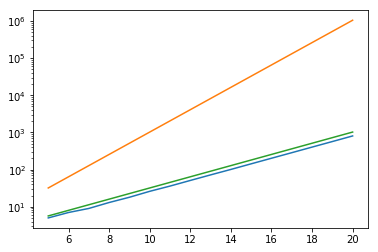

In [14]:
#計算結果

plt.plot([i+5 for i in range(num_samp)],result)
#2^n でスケール
plt.plot([i+5 for i in range(num_samp)],[pow(2,i+5) for i in range(num_samp)])
#2^(n/2)でスケール
plt.plot([i+5 for i in range(num_samp)],[pow(2,(i+5)/2) for i in range(num_samp)])
plt.yscale('log')
plt.show()

ステップ数が$2^{n/2}$でスケールしていることがわかった。